In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
def f(x,y):
  return 1


In [45]:
def tr_rectangulo(dx, dy, intv_h, intv_v):
  nx= int((intv_h[1]-intv_h[0])/dx)+1 #número de puntos en el eje horizontal
  ny= int((intv_v[1]-intv_v[0])/dy)+1 #número de puntos en el eje vertical
  nvert= nx*ny    #número de nodos
  ntri= (nx-1)*(ny-1)*2   #número de elementos

  #creamos la malla de puntos
  xvec= np.linspace(intv_h[0],intv_h[1],nx)
  yvec= np.linspace(intv_v[0],intv_v[1],ny)
  X,Y= np.meshgrid(xvec,yvec)
  vertices= np.vstack([X.flatten(),Y.flatten()]).T

  #creamos la matriz de conexiones
  triangles= np.zeros((ntri,3), dtype=int)
  desp_arriba= nx
  desp_dcha= 1
  ind_base_col= 0
  ind_base= 0
  for ind_cuadrado in range(0,(nx-1)*(ny-1)):
    triangles[2*ind_cuadrado,:]= np.array([ind_base, ind_base+desp_dcha,
                                           ind_base+desp_dcha+desp_arriba])
    triangles[2*ind_cuadrado+1,:]= np.array([ind_base+desp_arriba+desp_dcha, ind_base+desp_arriba,
                                              ind_base])
    ind_base= ind_base+desp_arriba
    if (ind_cuadrado+1) % (ny-1)==0:
      ind_base_col= ind_base_col+1
      ind_base= ind_base_col
  return vertices, triangles



In [46]:
#Funciones nodales
def phis_el(x,y,a,b,c,area):
  phis_array=np.zeros((3,))
  for k in range(0,3):
    phis_array[k]=(1/(2*area))*(a[k]+b[k]*x+c[k]*y)
  return phis_array

In [47]:
def matrices_sistema(vertices, triangles, dx, dy):
  nvert=vertices.shape[0]
  ntri=triangles.shape[0]
  K=np.zeros((nvert,nvert)) #Matriz global de rigidez
  F=np.zeros((nvert,1)) #Vector columna

  for e in range(0,ntri):
    K_el=np.zeros((3,3))
    F_el=np.zeros((3,1))
    P0=np.array([vertices[triangles[e,0],0],vertices[triangles[e,0],1]]) #coordenadas del nodo local 0
    P1=np.array([vertices[triangles[e,1],0],vertices[triangles[e,1],1]]) #coordenadas del nodo local 1
    P2=np.array([vertices[triangles[e,2],0],vertices[triangles[e,2],1]]) #coordenadas del nodo local 2

    m01=1/2*(P1+P0) #punto medio del segmento P0P1
    m02=1/2*(P2+P0) #punto medio del segmento P0P2
    m12=1/2*(P2+P1) #punto medio del segmento P1P2
    m=np.array([m01,m02,m12])

    a=np.array([P1[0]*P2[1]-P2[0]*P1[1], P2[0]*P0[1]-P0[0]*P2[1], P0[0]*P1[1]-P1[0]*P0[1]])
    b=np.array([P1[1]-P2[1], P2[1]-P0[1], P0[1]-P1[1]])
    c=np.array([P2[0]-P1[0], P0[0]-P2[0], P1[0]-P0[0]])

    area=(dx*dy)/2

    for i in range(0,3):
      sum=0
      for k in range(0,3):
        sum=sum+f(m[k][0],m[k][1])*phis_el(m[k][0],m[k][1],a,b,c,area)[i]

      #Aproximación de la integral por cuadratura en un triángulo
      F_el[i]=(1/3)*area*sum
      F[triangles[e,i],0]=F[triangles[e,i],0]+F_el[i][0]
      for j in range(i,3):
        K_el[i,j]=(1/(4*area))*(b[i]*b[j]+c[i]*c[j])
        K_el[j,i]=K_el[i,j]
        K[triangles[e,i],triangles[e,j]]=K[triangles[e,i],triangles[e,j]]+K_el[i,j]
        K[triangles[e,j],triangles[e,i]]=K[triangles[e,i],triangles[e,j]]

  return K, F

In [48]:
def es_frontera_rect(dx, dy, intv_h, intv_v):
  nx= int((intv_h[1]-intv_h[0])/dx)+1 #número de puntos en el eje horizontal
  ny= int((intv_v[1]-intv_v[0])/dy)+1 #número de puntos en el eje vertical
  nvert= nx*ny    #número de nodos
  ntri= (nx-1)*(ny-1)*2   #número de elementos

  es_frontera=np.ones((nvert,), dtype=int)
  for i in range(0,nvert):
    cond1=i<nx
    cond2=i%nx==0
    cond3=i%nx==(nx-1)
    cond4=nx*(ny-1)<= i<= nx*(ny-1)+(nx-1)
    if cond1 or cond2 or cond3 or cond4:
      es_frontera[i]=0
  return es_frontera

In [49]:
def new_system(K, F, dx, dy, intv_h, intv_v):
  nvert=F.shape[0]
  posiciones=np.arange(nvert) #Guardamos las posiciones originales delas filas\columnas
  K_new=K
  F_new=F
  es_frontera=es_frontera_rect(dx, dy, intv_h, intv_v)

  for i in range(0,nvert):
    if es_frontera[i]==0:
      quitas=np.argwhere(posiciones == i)[0] #Posición de la fila y columna en K_new que vas quitar
      K_new=np.delete(np.delete(K_new, quitas, 0),quitas,1)
      F_new=np.delete(F_new, quitas, 0)
      posiciones=np.delete(posiciones, quitas, 0)

  #Resolvemos el nuevo sistema
  sol=np.zeros((nvert,1))
  if K_new.shape[0]==1:
    sol[posiciones[0]]=F_new[0]/K_new[0]
  else:
    sol_int=np.linalg.solve(K_new,F_new)
    sol[posiciones]=sol_int
  sol=sol.reshape(nvert)

  return sol

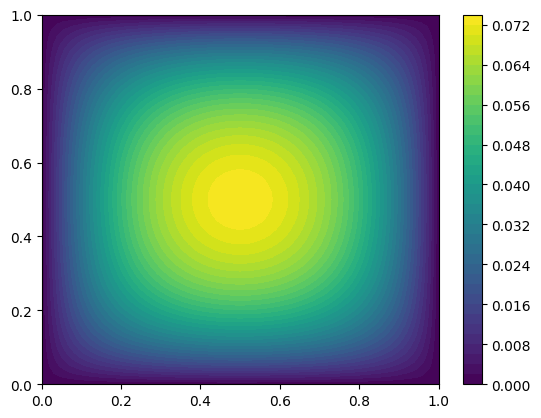

In [50]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os

# Datos iniciales de la malla de puntos
intv_h, intv_v = [0,1], [0,1]
dx, dy = 1/50, 1/50
nx= int((intv_h[1]-intv_h[0])/dx)+1
ny= int((intv_v[1]-intv_v[0])/dy)+1

# Creamos la malla de puntos
xvec = np.linspace(0,1,nx)
yvec = np.linspace(0,1,ny)
X,Y = np.meshgrid(xvec,yvec)

vertices, triangles=tr_rectangulo(dx, dy, intv_h, intv_v)
K, F=matrices_sistema(vertices, triangles, dx, dy)
sol=new_system(K, F, dx, dy, intv_h, intv_v)

# Convertimos nuestra triangulación en un objeto que pueda leer
# la función tricontourf
triang = tri.Triangulation(X.flatten(), Y.flatten(), triangles)

# Creamos plot
plt.tricontourf(triang, sol, 40, cmap='viridis')
plt.colorbar()
# Guardar el gráfico en el directorio 'cuadrado1'
directory = 'cuadrado1'
if not os.path.exists(directory):
    os.makedirs(directory)

plt.savefig(os.path.join(directory, 'cuadrado_2'))
plt.show()
